# Identifying Cells with Optogenetics

In this section, you will learn how to access the optogenetic data within the AllenSDK's Neuropixels dataset. In these experiments, light-gated ion channels were expressed in mice in a Cre-dependent manner. These ion channels can depolarize Cre+ cells when specific wavelengths of light are shined on the brain.

Although it can be hard to identify cell types with extracellular electrophysiology, the integration of optogenetics into these experiments is one way to help identify subsets of cells. Only units with our cre-line of interest will respond to the light allowing for subgroups of neuronal untis to be identified and analyzed across differing genotypes. This technique is called **optotagging**.

**Note**: the presence of light artifacts can create the appearance of false positives, and false negatives (cells that are Cre+ but do not respond to light) are nearly impossible to avoid. We will go over how to deal with these cases later in the notebook. 

In [9]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    if allensdk.__version__ == '2.11.2':
        print('allensdk already installed.')
    else: 
        print('incompatible version of allensdk installed')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [10]:
# Import necessary packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Assign where data will be stored
manifest_path = 'manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

print('Packages imported and cache instance created.')

Packages imported and cache instance created.


Because optogenetic channels are expressed in a Cre-dependent manner, let's first see which Cre-lines are available.

In [11]:
all_sessions = cache.get_session_table()
all_sessions['full_genotype'].unique()

array(['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'], dtype=object)

**About these transgenic mouse lines**

At the time we created this notebook, there were three transgenic mouse lines available: Sst-IRES-Cre, Pvalb-IRES-Cre, and Vip-IRES-Cre. Each of these Cre-lines mark specific subsets of inhibitory neurons in the brain. You can find a brief description as well as two-photon images of these transgenic lines on the<a href = 'https://observatory.brain-map.org/visualcoding/transgenic'> Allen Brain Atlas website</a>.

You might also notice that these lines are crossed with a mouse line called "Ai32" -- that's a mouse line that expresses a channelrhodopsin optogenetic channel (ChR2) in a cre-dependent manner. It also expresses yellow florescent protein (EYFP) so that researchers can see the cells expressing ChR2.

## Accessing Optogenetic Data

Before we begin downloading data, it is important to mention that there were two different means of light stimulation used in these experiments. The light used to evoke the units' optogenetic response was switched from an LED light to a laser a little more than halfway through data collection to evoke a stronger response from the units. 

To ensure we can see clear optogenetic responses from our units, we will be working with a session that used a laser to evoke these responses. In the cell below, we will filter our dataframe down to Pvalb-IRES-Cre mice and laser sessions only, and then download a session from a Pvalb-Cre session because they fire at high rates and are the most common in the cortex.

In [12]:
# Laser experiments began on session 789848216
laser_sessions = all_sessions.loc[all_sessions.index.values >= 789848216]

# Filter for Pvalb mice
pvalb_laser_sessions = laser_sessions[laser_sessions.full_genotype == 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt']

pvalb_laser_sessions

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
829720705,2019-10-03T00:00:00Z,811322619,functional_connectivity,112.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,529,1841,5,"[SCig, SCop, SCsg, SCzo, POST, VISp, nan, CA1,..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."


Now, we can select one of these sessions to download the data. Below, we'll choose session `829720705`. Depending on the speed of your internet connection, the next cell will take ~5-10 minutes to run. Do not interrupt the notebook while the data is downloading.

In [13]:
# Download a Pvalb laser session
session_id = 829720705
session = cache.get_session_data(session_id)
type(session)
print('Session Downloaded.')

Session Downloaded.


The optotagging stimuli are different than the stimulation presentations that were used in the previous section. To access the table containing the optogenetic stimuli data, execute `optogenetic_stimulation_epochs` on the session object. The table contains the start, stop, and duration of each light pulse as well as the pulse's condition and level. The `level` column contains the power level of the light source defined by the peak voltage of the control signal delivered to the light source. The type of pulse used is stored in the `condition` column and each pulse is defined below. 

- single square pulse: 5ms or 10ms duration
- half period of a cosine wave: 1 second duration
- 2.5 ms pulses at 10 Hz: 1 second duration

In [14]:
opto_table = session.optogenetic_stimulation_epochs
opto_table.head()

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9208.46044,a single square pulse,2.0,9208.46544,pulse,0.005
1,9210.64062,a single square pulse,1.7,9210.65062,pulse,0.010
2,9212.37064,2.5 ms pulses at 10 Hz,1.7,9213.37064,fast_pulses,1.000
3,9214.40076,2.5 ms pulses at 10 Hz,1.3,9215.40076,fast_pulses,1.000
4,9216.55091,2.5 ms pulses at 10 Hz,2.0,9217.55091,fast_pulses,1.000


## Aligning Spikes to Pulses 

Unlike the stimulus presentations that we covered in the previous section, there is no built in function for aligning spikes to light pulses in the Allen SDK. Below, we have copied a function from the <a href = 'https://github.com/jsiegle/AllenSDK/blob/opto-tutorial/doc_template/examples_root/examples/nb/ecephys_optotagging.ipynb'> Allen SDK Optotagging Analysis tutorial</a> that does this for you.

The function below needs `bin edges`, `optogenetic trials`, and `units` in order to return the spike counts. For this reason, you must first specify your desired bins, optogenetic stimuli, and units of interest. We will be focusing units found in the `VISp` brain area. The Allen Institute has discovered that "10 ms pulses are the most useful stimulus for finding true light-evoked activity" so will subselect data with that stimulus.

In [15]:
# Assign optogenetic stimuli (trials)
ss_10ms = opto_table[(opto_table['duration'] > 0.009) & (opto_table['duration'] < 0.02)]

# Assign units in brain area of interest (units)
units_df = session.units
VISp_df = units_df[units_df['ecephys_structure_acronym'] == 'VISp']

# Assign time bins (time bins)
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)



def optotagging_spike_counts(bin_edges, trials, units):
     
    time_resolution = np.mean(np.diff(bin_edges))
    
    # list of lists of lists / each block is trial, each row in block is a unit
    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    # unit_idx = 'index' for the list of unit_ids made from units.index.values
    # will have index '0-n' instead of unit_id being the index
    # unit_id =  actual unit_id from units_df
    # looping for every unit_id that we specify interest in
    for unit_idx, unit_id in enumerate(units.index.values):
        
        # get spike times for ONE unit by subselecting a unit id
        spike_times = session.spike_times[unit_id]
    
        # for each unit, loop for each trial of the specified stimulus
        for trial_idx, trial_start in enumerate(trials.start_time.values):
            
            # Determine what spike times for a unit fall with the duration of the trial 
            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values, 
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, ss_10ms, VISp_df)

The function returns an `xarray.DataArray` that contains the spikes counts of each units. The dimensions for the array are the `trial_id` (an individual pulse from `opto_table`) the `time_relative_to_stimulus_onset`, and the `unit_id`. 

Looking at the DataArray, we can see that in this session there were 75 different times that a 10ms single pulse was given and 46 different units we are focusing on based on brain area. 

We can use the DataArray to plot a heatmap of the units' response to the light pulses. The function below is also borrowed from the [Allen SDK Optogenetic Analysis tutorial](https://github.com/jsiegle/AllenSDK/blob/opto-tutorial/doc_template/examples_root/examples/nb/ecephys_optotagging.ipynb). The function takes our DataArray and reduces the data within by computing the mean spike counts across the `trial_id` dimension for every unit in the array. The reduced data is then plotted with respect to the time bins that we specified earlier. 

For more information on how to use `xarray.DataArray` objects, please visit the <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean'> xarray original documentation online</a>.

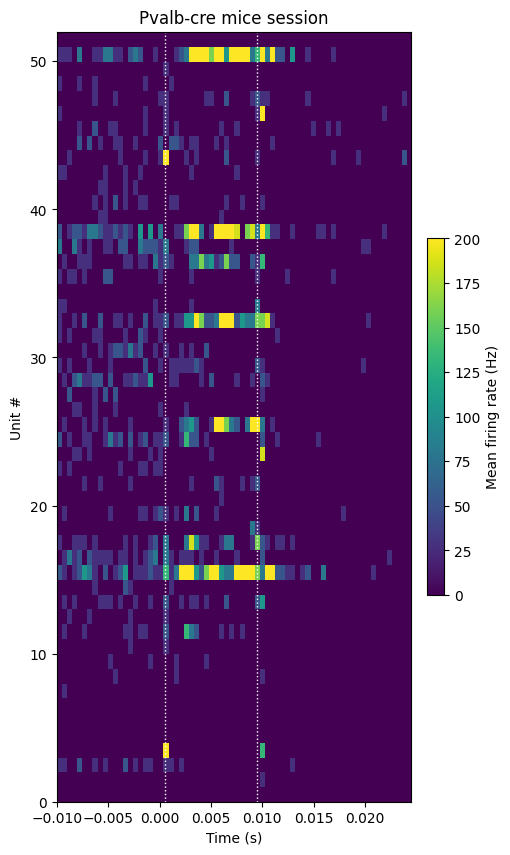

In [16]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))
    
    # Plot mean firing rate of each unit across each trial
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(VISp_df)],
               aspect='auto', vmin=0, vmax=200)    # Does this have to be hard coded?
    
    # Plot Vertical lines indicating stimulus window 
    for bound in [0.0005, 0.0095]: # THIS IS HARD CODED; CAN WE FIX IT
        plt.plot([bound, bound],[0, len(VISp_df)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)
plt.title('Pvalb-cre mice session')
plt.show()

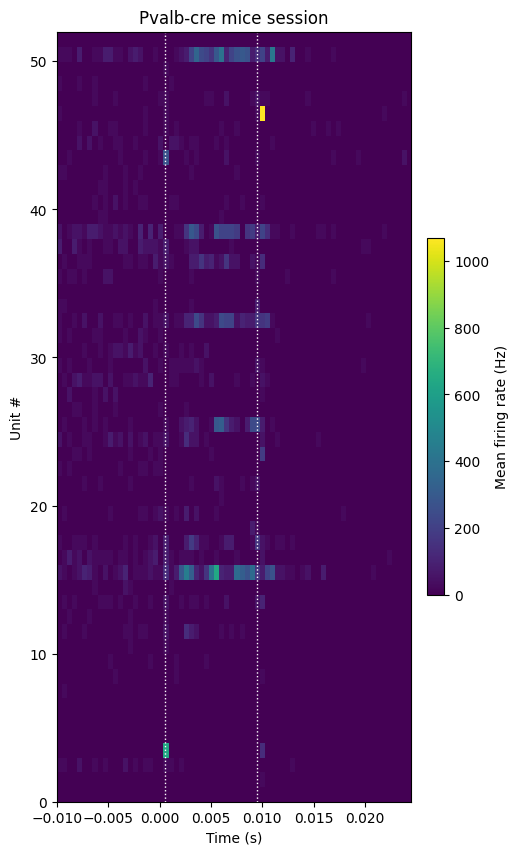

In [17]:
# Removed function
plt.figure(figsize=(5,10))
    
# Plot mean firing rate of each unit across each trial
plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
           extent=[np.min(bin_edges), np.max(bin_edges),
                   0, len(VISp_df)],
           aspect='auto')    # Removed hard coded color bar range
    
# Plot Vertical lines indicating stimulus window 
for bound in [0.0005, 0.0095]: # THIS IS HARD CODED; CAN WE FIX IT
    plt.plot([bound, bound],[0, len(VISp_df)], ':', color='white', linewidth=1.0)

plt.xlabel('Time (s)')
plt.ylabel('Unit #')

cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')
    
plt.title('Pvalb-cre mice session')
plt.show()

A useful analysis with this data would be to compare the baseline firing rate (i.e. firing rate before stimulus) to the evoked firing rate. We can do this by first slicing our time bins into two timeframes, `baseline` and `evoked`. The `baseline` timeframe will begin at the start of our time bins and end just before the stimulus onset. The `evoked` timeframe will begin immediately after the onset of the stimulus and end right before the end of the stimulus suration. 

We will then reduce our data to only the mean firing rate of each unit within each time frame.

In [18]:
# Assign time before stimulus occurs
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002)) # ALSO HARD CODED

# Calculate Mean firing rate of each unit for time before the stimulus window 
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

# Assign time within stimulus window
evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

# Calculate Mean firing rate of each unit for time within the stimulus window 
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked_rate

<xarray.DataArray 'spike_counts' (unit_id: 52)>
array([  0.        , 198.33333333,   0.        ,   1.66666667,
         6.66666667,   0.        ,   5.        ,  15.        ,
         6.66666667,   3.33333333,   0.        ,   6.66666667,
         1.66666667, 131.66666667,  10.        ,  55.        ,
         1.66666667,   0.        ,   1.66666667, 110.        ,
         0.        ,   6.66666667,  13.33333333,  10.        ,
         0.        ,   1.66666667,  81.66666667,  18.33333333,
         1.66666667,   0.        ,   8.33333333,   1.66666667,
        11.66666667,   0.        ,  38.33333333,  11.66666667,
       235.        ,   1.66666667,  10.        ,   0.        ,
        21.66666667,   0.        ,   3.33333333,   1.66666667,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   3.33333333,   0.        ,   0.        ])
Coordinates:
  * unit_id  (unit_id) int64 951132060 951132054 ... 951132308 951132419

We now have two DataArrays, one that contains the mean firing rate of the units at baseline, and one that contains the mean firing rate of the units during the pulse. Plotting a scatter plot with these two areas will show us how a unit's basline firing rate compares to its evoked firing rate. 

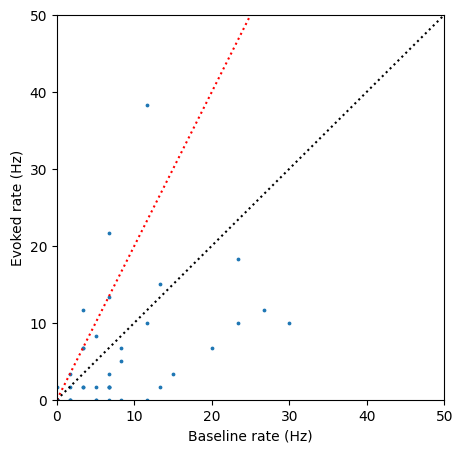

In [21]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

# Black line though center represents no change in rate (1:1)
axis_limit = 50
plt.plot([0,axis_limit],[0,axis_limit], ':k')

# Red line represents a 2x change in rate (2:1)
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')

# Restrict the axis for visualization
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
plt.ylabel('Evoked rate (Hz)')

plt.show()

Each point represent a neural unit. The black line represents a 1:1 ratio in the evoked firing rate to the baseline firing rate of that unit. Any unit below that black line had a larger response at baseline than it did to the light pulse. The red line represents a 2:1 ratio in the evoked firing rate to the baseline firing rate of that unit. We can subselect units whose evoked firing rate is 2x larger than baseline to define the cre+ units.

## Identifying Fast-Paced Waveforms

Defining what units are cre+ from those that are cre- is the first step in comparing optogenetic responses. Below we will create two lists, one with IDs of units who had an evoked firing rate 2x greater than baseline, and one with IDs of units whose evoked response was smaller than 2x the baseline. 

In [22]:
# Return units whose firing rates doubled when light was on
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors

# also get cre neg units
cre_neg_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) < 2].values

print("Pvalb+ Cre units")
print(cre_pos_units)

print(' \n Pvalb- Cre units')
print(cre_neg_units)

Pvalb+ Cre units
[951132054 951132138 951132140 951132159 951132184 951132212 951132205
 951132224 951132236]
 
 Pvalb- Cre units
[951132060 951132379 951132066 951132064 951132062 951132381 951132070
 951132078 951132090 951132092 951132112 951132124 951132136 951132393
 951132395 951132153 951132175 951132173 951132171 951132179 951132399
 951132189 951132197 951132195 951132203 951132401 951132218 951132208
 951132226 951132403 951132220 951132459 951132234 951132232 951132230
 951132405 951132254 951132258 951132288 951132290 951132302 951132308
 951132419]


Lets take a look at the wavefroms of cre+ units and see how they compare to cre- units. 

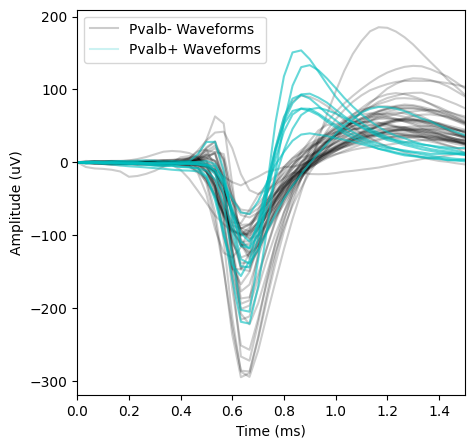

In [23]:
plt.figure(figsize=(5,5))
    
for unit_id in cre_neg_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.2)    

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)    
    plt.plot(wv.time * 1000, wv, 'c', alpha=0.6)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0,1.5]) # Plot just 1.5 ms

# Create the legend
plt.legend(['Pvalb- Waveforms','Pvalb+ Waveforms'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')
leg.legendHandles[1].set_color('c')

#plt.plot([1.0, 1.0],[-160, 100],':c') # REMOVING THIS UNTIL WE KNOW WHAT IT IS
plt.show()

As you can see, our Pvalb-positive waveforms (in cyan) are more narrow than the Pvalb-negative waveforms. These are indeed different cell types, marked by their ability to spike very fast!